In [1]:
# The code was removed by Watson Studio for sharing.

# Team Assignment 1: EDA of Bakery Sales 

Our team’s task was to analyze the data of a small bakery in the historic district of Edinburgh (Scotland) that is struggling with its assortment, and to develop recommendations that would make it more profitable. There are multiple aspects we could have chosen to look into. Since we found that labor costs can have a large cost on bakeries bottom line we chose to look into how we could reccomend a more effective staffing plan. Our reccomendations will also affect hours which can give the bakers more time to think about and plan assortment as well as spend time with their family. 

## Problem: How can we optimize the staffing schedule to increase net income and customer experience?

## Start by importing the python packages you will need for your analysis

In [2]:
# import the packages you will need for your analysis here
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Now import the data set (csv file)into a pandas data frame

In [3]:
bakery_file = project.get_file('BreadBasket_DMS.csv') # using token the access the file
bakery = pd.read_csv(bakery_file)

## Let's remove records with missing data

In [4]:
# clean the dataset because some items here are missing.
# Hint: the missing data is represented as 'NONE'
bakery = bakery.drop(bakery[bakery.Item == 'NONE'].index)
clean_sku_count = bakery.Item.count()  # clean item count

## Now let's use the date and time columns to add more helpful categorizations

In [131]:
bakery.Date = pd.to_datetime(bakery.Date) 
bakery.Time = pd.to_datetime(bakery.Time)
bakery['Hour'] = bakery.Time.dt.strftime('%I %p')
bakery['Hour Num'] = bakery.Time.dt.hour
bakery['Weekday'] = bakery.Date.dt.weekday_name
bakery.head(10)

,Date,Time,Transaction,Item,Hour,Weekday,Shift,Hour Num
0,2016-10-30,2020-02-02 09:58:11,1,Bread,09 AM,Sunday,First,9
1,2016-10-30,2020-02-02 10:05:34,2,Scandinavian,10 AM,Sunday,First,10
2,2016-10-30,2020-02-02 10:05:34,2,Scandinavian,10 AM,Sunday,First,10
3,2016-10-30,2020-02-02 10:07:57,3,Hot chocolate,10 AM,Sunday,First,10
4,2016-10-30,2020-02-02 10:07:57,3,Jam,10 AM,Sunday,First,10
5,2016-10-30,2020-02-02 10:07:57,3,Cookies,10 AM,Sunday,First,10
6,2016-10-30,2020-02-02 10:08:41,4,Muffin,10 AM,Sunday,First,10
7,2016-10-30,2020-02-02 10:13:03,5,Coffee,10 AM,Sunday,First,10
8,2016-10-30,2020-02-02 10:13:03,5,Pastry,10 AM,Sunday,First,10
9,2016-10-30,2020-02-02 10:13:03,5,Bread,10 AM,Sunday,First,10


## Now that we have those categories let's take a first look at the data to see if any staffing insights jump out

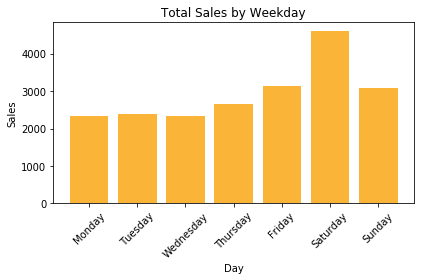

In [107]:
trans_by_weekday = bakery.Weekday.value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.bar(trans_by_weekday.index, trans_by_weekday.values, color = (.98,.71,.22,1))
plt.xlabel('Day')
plt.xticks(rotation = 45)
plt.ylabel('Sales')
plt.title('Total Sales by Weekday')
plt.tight_layout()
plt.show()

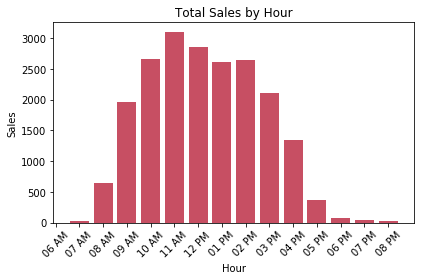

In [104]:
trans_by_hour = bakery.Hour.value_counts().reindex(['06 AM','07 AM','08 AM','09 AM','10 AM','11 AM','12 PM','01 PM','02 PM' ,'03 PM','04 PM','05 PM','06 PM','07 PM','08 PM'])
plt.bar(trans_by_hour.index, trans_by_hour.values, color = (.78,.31,.39,1))
plt.xlabel('Hour')
plt.xticks(rotation = 45)
plt.ylabel('Sales')
plt.title('Total Sales by Hour')
plt.tight_layout()
plt.show()

## Insights
After looking at these two graphs it is clear that the bakery could probably use more staff on Saturdays and is open for some hours that might not be profitable. Now, let's take this a step further with some outside data to quantify these observations.

In [159]:
temp_bakery = bakery.groupby(['Date', 'Weekday'], as_index = False).count()
num_weekdays = temp_bakery.Weekday.value_counts()
## num_weekdays is used later to find average sales per hour, using the simple average would ignore days in which no sales were made
temp_bakery = bakery.groupby(['Date','Weekday', 'Hour', 'Hour Num'], as_index = False).count()
hours_plan = temp_bakery.groupby(['Weekday', 'Hour', 'Hour Num'], as_index = False).agg({'Transaction' : 'sum'}).sort_values(by = ['Weekday','Hour Num'])
hours_plan['Number of Days'] = [num_weekdays[x] for x in list(hours_plan['Weekday'])]
hours_plan['Average Sales per Hour'] = hours_plan['Transaction'] / hours_plan['Number of Days'] #average sales calculation
average_sales_rev = 2.52 #in pounds based on average of many bakery item prices
average_prof_marg = .586 #ignoring overhead and bakers labor
cost_per_emp_hour = 8.21 #minimum wage in Scotland
two_emp_threshold = 19.4 #based on report with average transactions per cashier
hours_plan.rename(columns = {'Transaction' : 'Number of Sales'}, inplace = True)
#Columns below help decide when EDA will be open and when they will need two employees. It then uses this to calculate profitability
hours_plan['Profitable Hour?'] = (hours_plan['Average Sales per Hour'] * average_sales_rev * average_prof_marg) >= cost_per_emp_hour
hours_plan['Two Cashiers Needed?'] = hours_plan['Average Sales per Hour'] > two_emp_threshold
hours_plan['Profitability'] = (hours_plan['Average Sales per Hour'] * average_sales_rev * average_prof_marg) - ((1+ (1 * hours_plan['Two Cashiers Needed?'])) * cost_per_emp_hour)
hours_plan.head()

,Weekday,Hour,Hour Num,Number of Sales,Number of Days,Average Sales per Hour,Profitable Hour?,Two Cashiers Needed?,Profitability
6,Friday,07 AM,7,1,23,0.043478,False,False,-8.145795
8,Friday,08 AM,8,144,23,6.260870,True,False,1.035551
10,Friday,09 AM,9,385,23,16.739130,True,False,16.509009
11,Friday,10 AM,10,392,23,17.043478,True,False,16.958445
12,Friday,11 AM,11,427,23,18.565217,True,False,19.205628


Here we have calculated the Average Sales per Hour and then used outside data to come up with Profitability and when we will need to employ 1 vs 2 cashiers.

## Now Let's Visualize the Profitability based on the hour of the day
This profit is ignoring overhead and the bakers salary and is assuming only one cashier is employed except when two are needed on Saturdays.

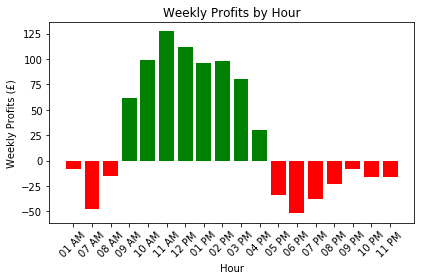

In [147]:
prof_by_hour = hours_plan.groupby(['Hour', 'Hour Num'], as_index = False).agg({'Profitability' : 'sum'}).sort_values(by = ['Hour Num'])
#profitability broken out by hour
prof_by_hour['Positive'] = prof_by_hour['Profitability'] > 0 #used to denote color
plt.bar(prof_by_hour['Hour'], prof_by_hour['Profitability'], color = prof_by_hour.Positive.map({True : 'g', False : 'r'})) #color mapping idea from Stack Overflow TomAugspurger
plt.xlabel('Hour')
plt.xticks(rotation = 45)
plt.ylabel("Weekly Profits (£)")
plt.title('Weekly Profits by Hour')
plt.tight_layout()
plt.show()

This confirms what we found earlier that some hours are not profitable for EDA and they should therefore close during those hours.

## Next we can quantify the savings of closing during these hours thus reducing labor costs

In [148]:
profitability_change = hours_plan.groupby(['Profitable Hour?']).agg({'Profitability' : 'sum'})
weekly_prof_before = profitability_change.iloc[0,0] + profitability_change.iloc[1,0]
weekly_prof_after = profitability_change.iloc[1,0]
weekly_perc_inc = ((weekly_prof_after / weekly_prof_before) - 1) * 100
print('Weekly Profits Before: £%.2f' % weekly_prof_before)
print('Weekly Profits After: £%.2f' % weekly_prof_after)
print("Profits will increase by %.2f%% each week" % weekly_perc_inc)

Weekly Profits Before: £444.19
Weekly Profits After: £709.18
Profits will increase by 59.66% each week


## Let's make the new schedule readable

In [164]:
schedule = {
    'Monday': [],
    'Tuesday': [],
    'Wednesday': [],
    'Thursday': [],
    'Friday': [],
    'Saturday': [],
    'Sunday': []
}
for index, row in hours_plan.iterrows():
    if row['Profitable Hour?']:
        schedule[row['Weekday']].append(row['Hour'])
print('Weekly Schedule is:')
for key in schedule.keys():
    items = schedule[key]
    print(key + ': ' + items[0] + ' - ' + items[-1])

Weekly Schedule is:
Monday: 09 AM - 04 PM
Tuesday: 09 AM - 04 PM
Wednesday: 09 AM - 04 PM
Thursday: 09 AM - 04 PM
Friday: 08 AM - 04 PM
Saturday: 08 AM - 04 PM
Sunday: 09 AM - 03 PM


## Finally we can export the table to present to ownership with details of our analysis

In [165]:
new_csv_file = hours_plan.to_csv(index=True) # this takes a Pandas dataframe and makes it a csv file

project.save_data("final_hours_plan.csv", new_csv_file, set_project_asset=True, overwrite=True)

{'file_name': 'final_hours_plan.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'busi488group1exercise1-donotdelete-pr-1fgmehvtiamjwg',
 'asset_id': 'f0e1933a-96d7-4fda-b9ac-adbab9d23541'}